# Notes:
Assumptions: <br>
- **Perfect foresight** on spot price <br>
- Battery does not degrade throughout the optimisation horizon <br>
- Battery cannot charge and discharge concurrently 

In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from battery_optimise import *
from check import check_submission
from algo_utils import plot_actions

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

To formulate the algorithm, we've treated the battery system as a linear programming problem. The following are the objective function, parameters, decision variables and operational constraint for the linear programming model. The objective function is the objective we would like to maximise, which is the revenue over the time horizon of optimisation. <br>
- The objective function:<br>
$\sum_{t=1}^{T}{P_t}(\frac{D_t{E}}{2}{\eta}-\frac{C_t}{2{\eta}})$ <br>
<br>
- Parameters: <br>
$T$: Time horizon of arbitrage <br>
$P_t$: Spot price at time t <br>
$E$: Charge and discharge efficiency of the battery <br>
$\eta$: Marginal Loss Factor <br>
<br>
- Decision Variables: <br>
$Capacity_t$: Opening Capacity at time t <br>
$C_t$: Charge Power at time t <br>
$D_t$: Discharge Power at time t <br>
<br>
- Opertaion Constraint: <br>
$Capacity_t = {Capacity_{t-1}} + \frac{C_t}{2}E - \frac{D_t}{2}$ <br>
$0 \leq {Capacity_t} \leq 580, \forall t \in T$ <br>
$0 \leq {C_t} \leq 300, \forall t \in T$ <br>
$0 \leq {D_t} \leq 300, \forall t \in T$ <br>
$D_t \leq \frac{Capacity_t\times{E}}{2}$ <br>
$when\; P_t < 0,\:D_t = 0$ <br>

## Simulate battery optimisation

In [2]:
# Read data
data = pd.read_csv("../../data/vic.csv")
data['time'] = pd.to_datetime(data['time'])
result = battery_optimisation(data.time, data.spot_price, solver='glpk')

In [3]:
result[50:75]

,datetime,spot_price,power,market_dispatch,opening_capacity,revenue
50,2018-01-02 01:00:00,56.32,0.00,0.00,0.00,0.00
51,2018-01-02 01:30:00,51.96,-300.00,-150.00,0.00,-7864.78
52,2018-01-02 02:00:00,53.57,-88.89,-44.44,135.00,-2402.51
53,2018-01-02 02:30:00,52.50,-300.00,-150.00,175.00,-7946.52
54,2018-01-02 03:00:00,53.61,0.00,0.00,310.00,0.00
55,2018-01-02 03:30:00,53.13,-300.00,-150.00,310.00,-8041.88
56,2018-01-02 04:00:00,53.75,0.00,0.00,445.00,0.00
57,2018-01-02 04:30:00,51.11,-300.00,-150.00,445.00,-7736.13
58,2018-01-02 05:00:00,66.34,0.00,0.00,580.00,0.00
59,2018-01-02 05:30:00,67.81,0.00,0.00,580.00,0.00


## Check output and evaluation

- Evaluate our result by running the provided function check.py, as we can see our output is acceptable.
- The battery was able to generate 131,327,433 dollars of revenue throughout the whole period.

Thanks to our tutor Calvin for providing the check.py function.

In [4]:
# Check flag and revenue
df = result[['datetime', 'power', 'opening_capacity']]
df.columns = ['datetime', 'power', 'capacity']
output = check_submission(df, result.spot_price, include_capacity=True, include_revenue=True)
print(output.groupby('flag').count(), '\n')
output['year'] = output['datetime'].dt.year
print('===== Revenue =====')
print(output.groupby('year')['revenue'].agg('sum').round())
print("Total Revenue:", output.revenue.sum().round())

      datetime  capacity  revenue
flag                             
0        63457     63457    63457 

===== Revenue =====
year
2018   33131652.00
2019   44279891.00
2020   30111788.00
2021   23804103.00
Name: revenue, dtype: float64
Total Revenue: 131327433.0


In [5]:
testing = output[(output['datetime'] >= '2021-01-01 00:00:00') & (output['datetime'] <= '2021-06-30 23:30:00')]
print('Cross Validation Period Revenue:', testing.revenue.sum().round())
testing = output[(output['datetime'] >= '2021-07-01 00:00:00') & (output['datetime'] <= '2021-08-11 23:30:00')]
print('Test Period Revenue:', testing.revenue.sum().round())

Cross Validation Period Revenue: 17669191.0
Test Period Revenue: 5821757.0


## Save results

In [6]:
# Save to csv file for submission
submission = result[['datetime', 'power', 'opening_capacity']]
submission.columns = ['datetime', 'power', 'capacity']
submission.to_csv('../../results/mandatory_submission.csv', index=False)

In [7]:
# Save result to csv
result.to_csv('../../results/result_perfect_foresight.csv', index=False)

## Visualise result

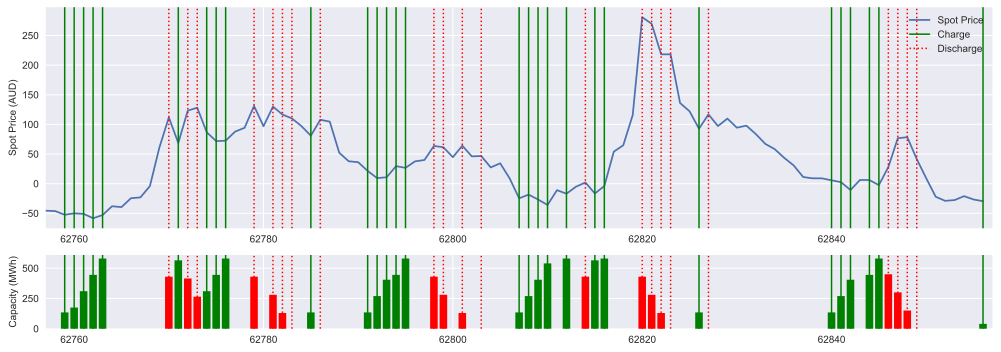

In [8]:
# Note: must convert opening capacity to closing capacity
closing_capacity = result.opening_capacity.shift(-1)
plot_actions(result.spot_price, result.power, closing_capacity=closing_capacity, start=-700, end=-600)